In [1]:
# Problem Statement
# predicting turbine energy yield (TEY) using ambient variables as features.

In [77]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
import ppscore as PPS
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
import warnings

In [3]:
# Reading csv file
data=pd.read_csv('gas_turbines.csv')

## EDA

In [4]:
data.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3  7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4  7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   

       CO     NOX  
0  3.1547  82.722  
1  3.2363  82.776  
2  3.2012  82.468  
3  3.1923  82.670  
4  3.2484  82.311

In [5]:
data.shape

(15039, 11)

In [6]:
data.describe()

AT           AP            AH          AFDP          GTEP  \
count  15039.000000  15039.00000  15039.000000  15039.000000  15039.000000   
mean      17.764381   1013.19924     79.124174      4.200294     25.419061   
std        7.574323      6.41076     13.793439      0.760197      4.173916   
min        0.522300    985.85000     30.344000      2.087400     17.878000   
25%       11.408000   1008.90000     69.750000      3.723900     23.294000   
50%       18.186000   1012.80000     82.266000      4.186200     25.082000   
75%       23.862500   1016.90000     90.043500      4.550900     27.184000   
max       34.929000   1034.20000    100.200000      7.610600     37.402000   

                TIT           TAT           TEY           CDP            CO  \
count  15039.000000  15039.000000  15039.000000  15039.000000  15039.000000   
mean    1083.798770    545.396183    134.188464     12.102353      1.972499   
std       16.527806      7.866803     15.829717      1.103196      2.222206   
min     1000.800000    512.450000    100.170000      9.904400      0.000388   
25%     1079.600000    542.170000    127.985000     11.622000      0.858055   
50%     1088.700000    549.890000    133.780000     12.025000      1.390200   
75%     1096.000000    550.060000    140.895000     12.578000      2.160400   
max     1100.800000    550.610000    174.610000     15.081000     44.103000   

                NOX  
count  15039.000000  
mean      68.190934  
std       10.470586  
min       27.765000  
25%       61.303500  
50%       66.601000  
75%       73.935500  
max      119.890000

In [7]:
data.info()     # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [8]:
data[data.duplicated()]     # no duplicates

Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []

In [9]:
cor=data.corr()
cor

AT        AP        AH      AFDP      GTEP       TIT       TAT  \
AT    1.000000 -0.412953 -0.549432 -0.099333 -0.049103  0.093067  0.338569   
AP   -0.412953  1.000000  0.042573  0.040318  0.078575  0.029650 -0.223479   
AH   -0.549432  0.042573  1.000000 -0.119249 -0.202784 -0.247781  0.010859   
AFDP -0.099333  0.040318 -0.119249  1.000000  0.744251  0.627254 -0.571541   
GTEP -0.049103  0.078575 -0.202784  0.744251  1.000000  0.874526 -0.756884   
TIT   0.093067  0.029650 -0.247781  0.627254  0.874526  1.000000 -0.357320   
TAT   0.338569 -0.223479  0.010859 -0.571541 -0.756884 -0.357320  1.000000   
TEY  -0.207495  0.146939 -0.110272  0.717995  0.977042  0.891587 -0.720356   
CDP  -0.100705  0.131198 -0.182010  0.727152  0.993784  0.887238 -0.744740   
CO   -0.088588  0.041614  0.165505 -0.334207 -0.508259 -0.688272  0.063404   
NOX  -0.600006  0.256744  0.143061 -0.037299 -0.208496 -0.231636  0.009888   

           TEY       CDP        CO       NOX  
AT   -0.207495 -0.100705 -0.088588 -0.600006  
AP    0.146939  0.131198  0.041614  0.256744  
AH   -0.110272 -0.182010  0.165505  0.143061  
AFDP  0.717995  0.727152 -0.334207 -0.037299  
GTEP  0.977042  0.993784 -0.508259 -0.208496  
TIT   0.891587  0.887238 -0.688272 -0.231636  
TAT  -0.720356 -0.744740  0.063404  0.009888  
TEY   1.000000  0.988473 -0.541751 -0.102631  
CDP   0.988473  1.000000 -0.520783 -0.169103  
CO   -0.541751 -0.520783  1.000000  0.316743  
NOX  -0.102631 -0.169103  0.316743  1.000000

In [10]:
# strong correlation:
# GTEP & TIT: 0.87
# GTEP & TEY: 0.97
# GTEP & CDP: 0.99
# TIT & TEY: 0.89
# TIT & CDP: 0.88
# TEY & CDP: 0.98
# GTEP, TIT & CDP are highly correlated with output # TEY

## Visualization

<Axes: >

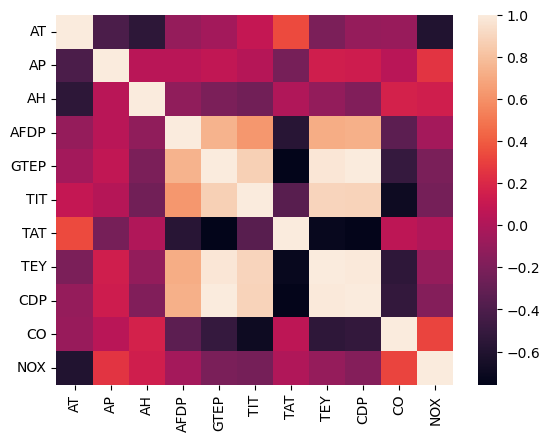

In [12]:
# heatmap
sns.heatmap(cor)

C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: ylabel='TEY'>

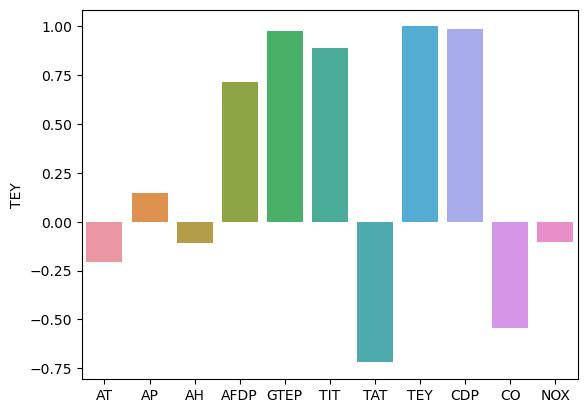

In [13]:
# correlation plot
sns.barplot(x = cor.index, y = cor.TEY)

C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

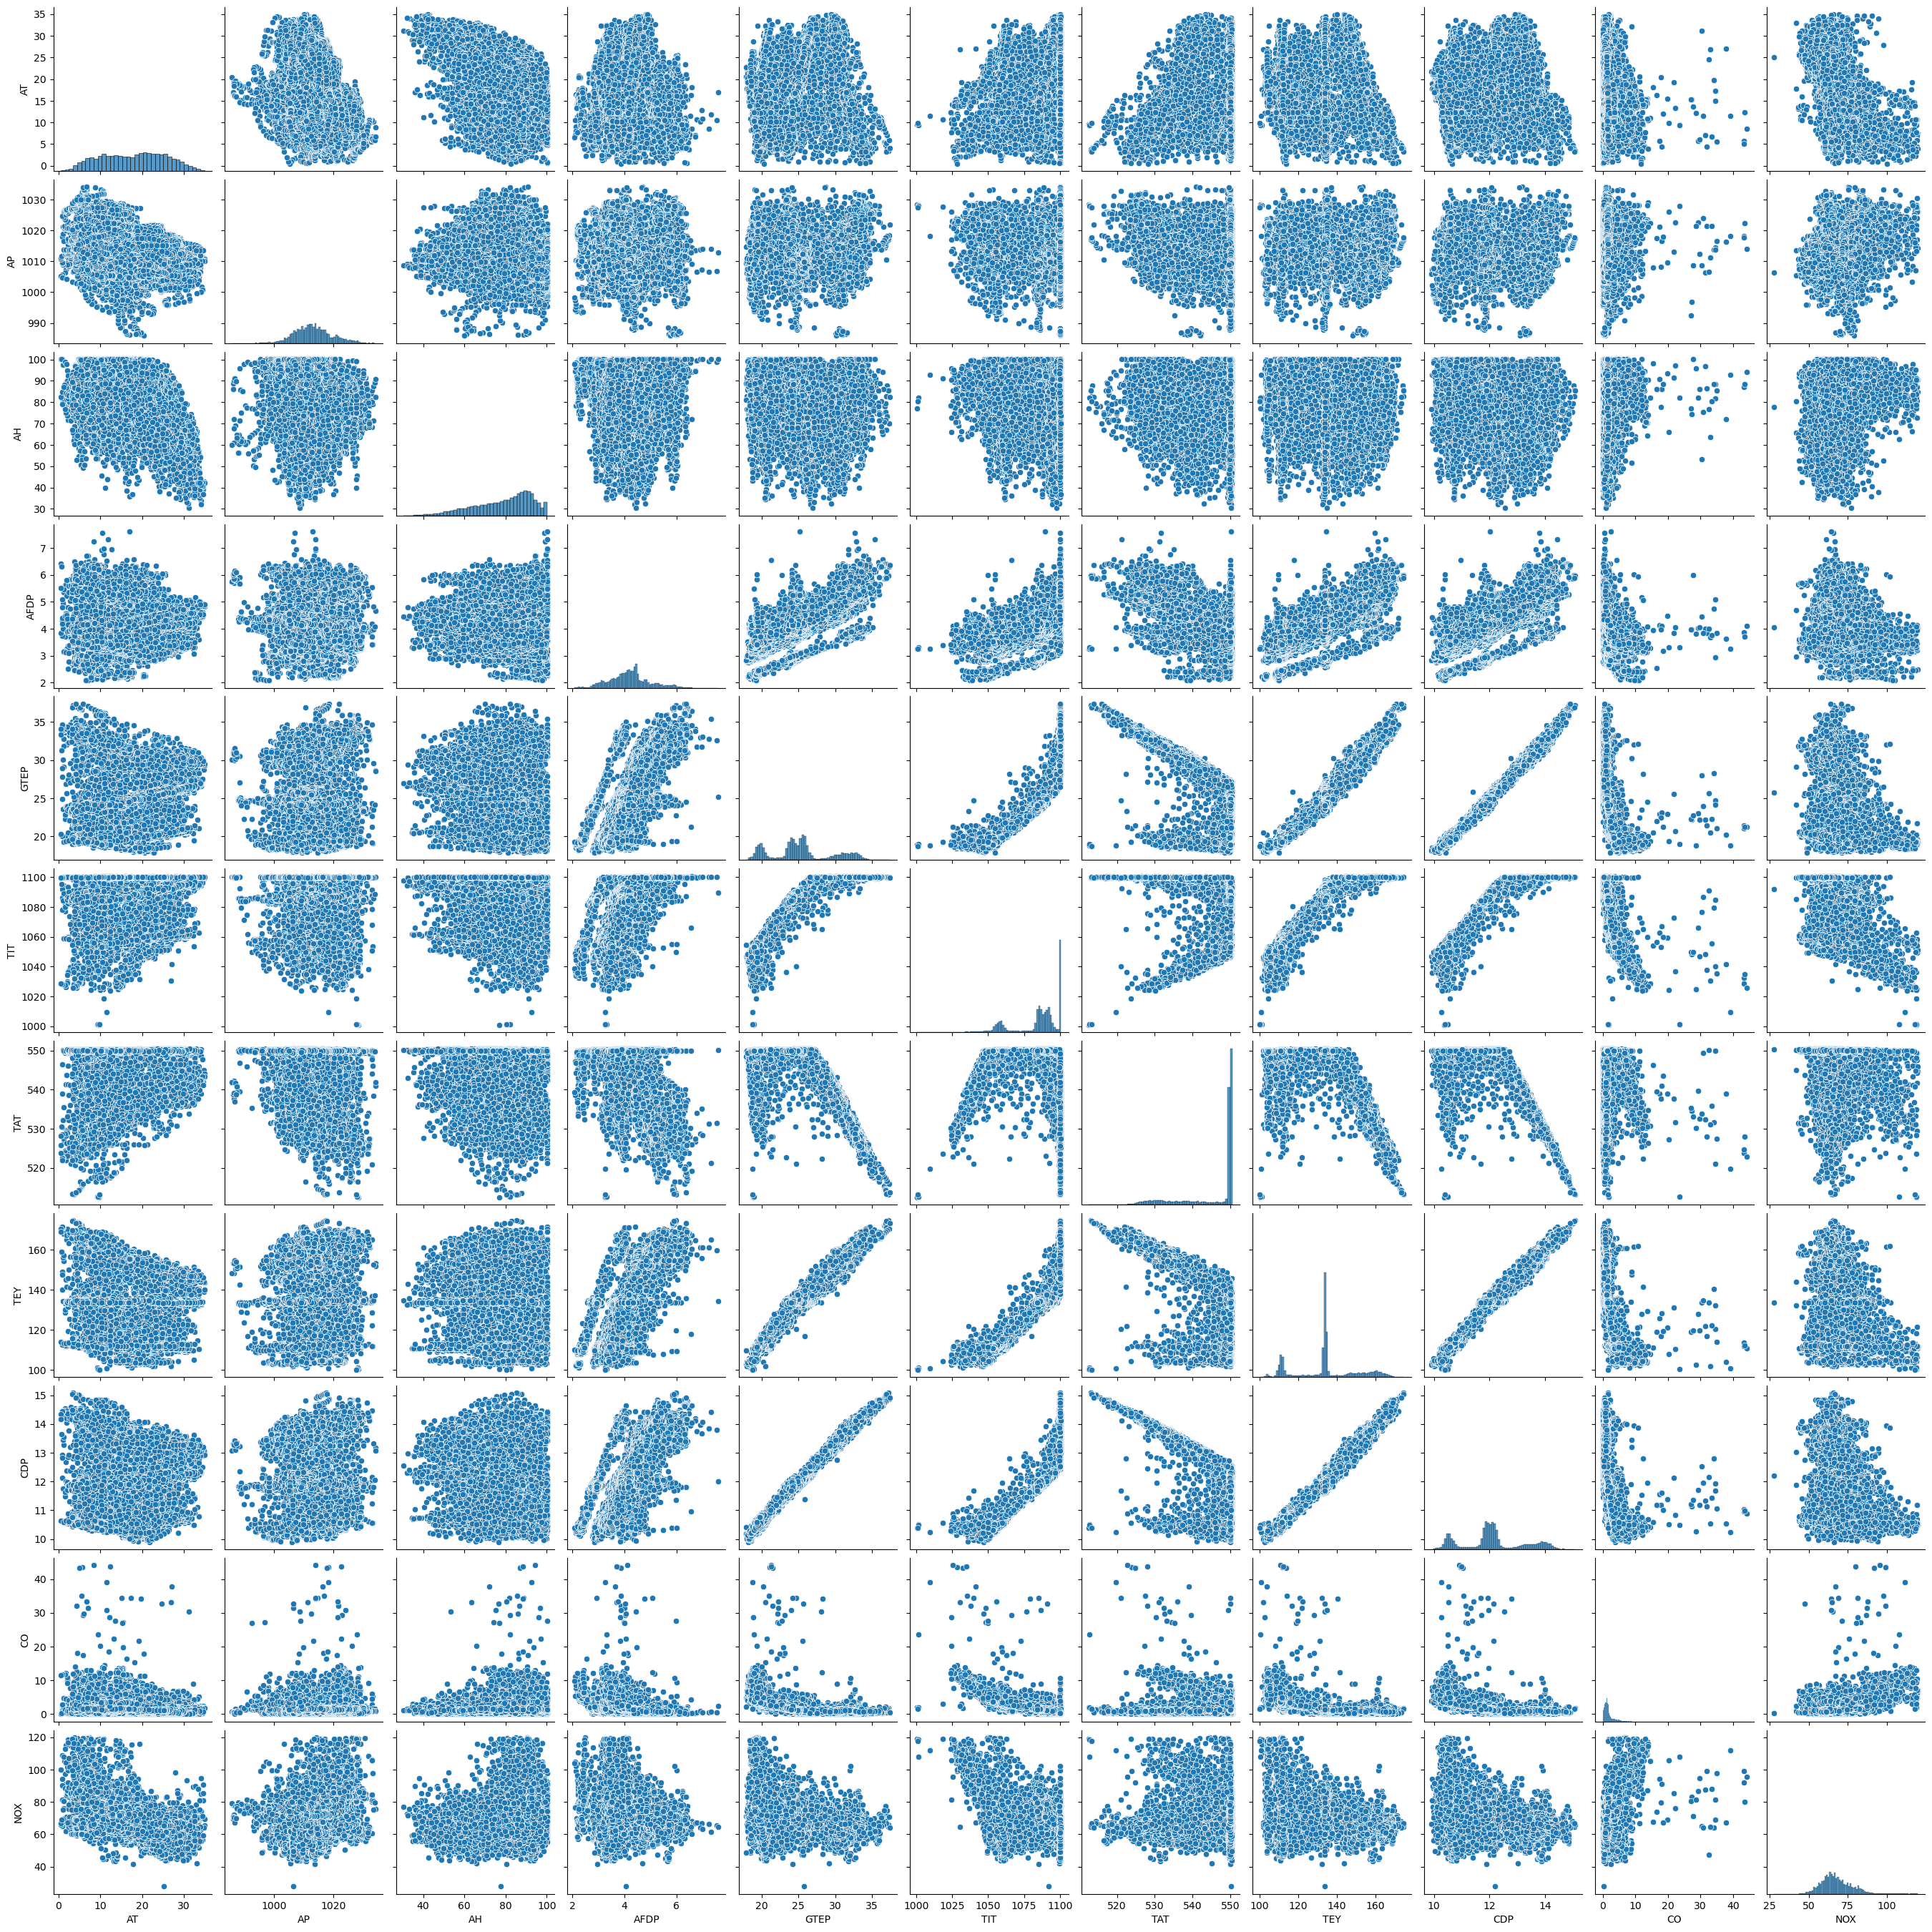

In [15]:
sns.pairplot(data)
plt.show()

In [16]:
score = PPS.matrix(data)
score_s = score[score['y']=='TEY']
score_s.sort_values(by="ppscore", ascending=False)

C:\Users\sycmy\anaconda3\Lib\site-packages\ppscore\calculation.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
C:\Users\sycmy\anaconda3\Lib\site-packages\ppscore\calculation.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
C:\Users\sycmy\anaconda3\Lib\site-packages\ppscore\calculation.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
C:\Users\sycmy\anaconda3\Lib\site-packages\ppscore\calculation.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
C:\Users\sycmy\anaconda3

x    y   ppscore            case  is_valid_score               metric  \
84    TEY  TEY  1.000000  predict_itself            True                 None   
95    CDP  TEY  0.872285      regression            True  mean absolute error   
51   GTEP  TEY  0.832336      regression            True  mean absolute error   
62    TIT  TEY  0.766040      regression            True  mean absolute error   
73    TAT  TEY  0.226050      regression            True  mean absolute error   
40   AFDP  TEY  0.152509      regression            True  mean absolute error   
106    CO  TEY  0.055869      regression            True  mean absolute error   
7      AT  TEY  0.000000      regression            True  mean absolute error   
18     AP  TEY  0.000000      regression            True  mean absolute error   
29     AH  TEY  0.000000      regression            True  mean absolute error   
117   NOX  TEY  0.000000      regression            True  mean absolute error   

     baseline_score  model_score                    model  
84         0.000000     1.000000                     None  
95        11.172076     1.426840  DecisionTreeRegressor()  
51        11.172076     1.873154  DecisionTreeRegressor()  
62        11.172076     2.613821  DecisionTreeRegressor()  
73        11.172076     8.646631  DecisionTreeRegressor()  
40        11.172076     9.468234  DecisionTreeRegressor()  
106       11.172076    10.547906  DecisionTreeRegressor()  
7         11.172076    16.007470  DecisionTreeRegressor()  
18        11.172076    12.475617  DecisionTreeRegressor()  
29        11.172076    16.950976  DecisionTreeRegressor()  
117       11.172076    14.537337  DecisionTreeRegressor()

C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sycmy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.01, 'PPScore of each feature with Target variable')

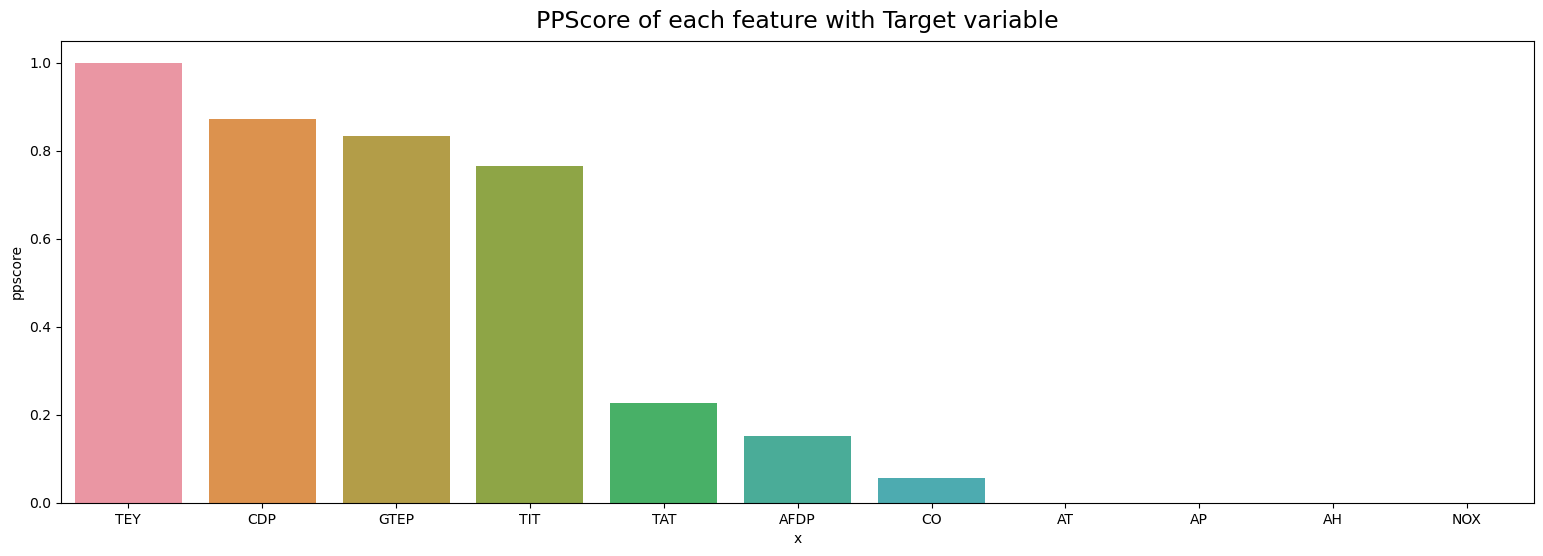

In [17]:
plt.rcParams['figure.figsize']=(19,6)
sns.barplot(x='x', y='ppscore', data=score_s.sort_values(by='ppscore', ascending=False))
plt.title("PPScore of each feature with Target variable", fontsize=17, y=1.01)

In [18]:
# Dropping AT, AP, AH, NOX as they have less impact

In [19]:
data2=data.drop(['AT', 'AP', 'AH', 'NOX'], axis=1)
data2.head(1)

AFDP    GTEP     TIT    TAT    TEY     CDP      CO
0   3.5  19.663  1059.2  550.0  114.7  10.605  3.1547

In [21]:
# getting outliers using Isolation Forest
df=data2.copy()
#training model
if_outlier= IsolationForest(random_state=10, contamination=.001)
if_outlier.fit(df)
df['anamoly'] = if_outlier.predict(df.iloc[:,0:7])
outliers = df[df['anamoly']==-1]

C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\sycmy\anaconda3\Lib\

In [22]:
outliers

AFDP    GTEP     TIT     TAT     TEY     CDP       CO  anamoly
261    3.8404  21.079  1028.5  523.86  112.02  10.963  43.4280       -1
262    3.8648  21.435  1032.5  524.71  113.60  11.029  43.3970       -1
396    4.0991  21.267  1025.6  522.79  110.79  10.899  44.1030       -1
6533   3.8262  18.856  1024.6  530.22  102.59  10.266  28.6390       -1
9920   2.7816  18.435  1027.8  533.45  103.64  10.143  12.1440       -1
13824  3.1408  18.753  1027.4  532.00  103.81  10.318  13.6570       -1
13825  3.1295  18.719  1027.2  531.75  103.80  10.317  13.5430       -1
13826  3.1457  18.739  1027.4  532.05  103.80  10.323  13.2790       -1
13828  3.1306  18.756  1026.4  531.47  103.80  10.320  13.4010       -1
13921  3.2518  18.784  1009.5  519.71  100.83  10.253  39.0500       -1
14085  3.2523  18.897  1000.8  512.45  100.52  10.380   1.9122       -1
14086  3.2668  18.835  1001.4  512.60  100.96  10.508   1.8939       -1
14100  3.3003  18.987  1001.4  512.60  100.32  10.495  23.6290       -1
14101  3.2687  18.764  1001.3  513.17  100.17  10.389   1.6564       -1

In [23]:
outliers.shape

(14, 8)

In [25]:
data2.shape

(15039, 7)

In [24]:
# deleting outliers 
data3= data2.drop(outliers.index)
data3.shape

(15025, 7)

In [26]:
#reset index after dropping outliers
data4=data3.reset_index()
data5=data4.drop('index', axis = 1)
data5.head()

AFDP    GTEP     TIT     TAT     TEY     CDP      CO
0  3.5000  19.663  1059.2  550.00  114.70  10.605  3.1547
1  3.4998  19.728  1059.3  550.00  114.72  10.598  3.2363
2  3.4824  19.779  1059.4  549.87  114.71  10.601  3.2012
3  3.4805  19.792  1059.6  549.99  114.72  10.606  3.1923
4  3.4976  19.765  1059.7  549.98  114.72  10.612  3.2484

In [27]:
data5.shape

(15025, 7)

## Scaling

In [28]:
# Normalising the data as there is scale difference
def norm_func(i):
    x= (i-i.min())/(i.max()-i.min())
    return (x)

In [29]:
df_norm= norm_func(data5)
df_norm.head()

AFDP      GTEP       TIT       TAT       TEY       CDP        CO
0  0.255758  0.091426  0.495758  0.983755  0.184454  0.135340  0.072311
1  0.255721  0.094755  0.496970  0.983755  0.184726  0.133988  0.074181
2  0.252571  0.097367  0.498182  0.980293  0.184590  0.134567  0.073377
3  0.252227  0.098033  0.500606  0.983489  0.184726  0.135533  0.073173
4  0.255323  0.096650  0.501818  0.983222  0.184726  0.136692  0.074459

In [43]:
#we will take a small model as this is large data and will take huge amount of time to build model
#to reandomly shuffle and select a % of data
temp=df_norm.sample(frac=1)          #shuffle all the data
temp_s=df_norm.sample(frac=0.1)      #shuffle and select only 10% of the data randomly to train

In [44]:
temp_s.head()

AFDP      GTEP       TIT       TAT       TEY       CDP        CO
4312   0.426963  0.452161  0.932121  0.976831  0.445685  0.446548  0.038098
2116   0.505667  0.371901  0.850909  0.981891  0.442962  0.404242  0.032285
12133  0.190270  0.125794  0.504242  0.992543  0.143752  0.124522  0.035854
8597   0.567207  0.719371  0.991515  0.474567  0.817043  0.753506  0.045402
12423  0.281250  0.316687  0.795152  0.980826  0.394092  0.368311  0.022028

## Splitting Data

In [45]:
x=temp_s.drop('TEY', axis=1)
y=temp_s['TEY']
print(x.head(),x.shape)

           AFDP      GTEP       TIT       TAT       CDP        CO
4312   0.426963  0.452161  0.932121  0.976831  0.446548  0.038098
2116   0.505667  0.371901  0.850909  0.981891  0.404242  0.032285
12133  0.190270  0.125794  0.504242  0.992543  0.124522  0.035854
8597   0.567207  0.719371  0.991515  0.474567  0.753506  0.045402
12423  0.281250  0.316687  0.795152  0.980826  0.368311  0.022028 (1502, 6)


In [46]:
print(y.head(),y.shape)

4312     0.445685
2116     0.442962
12133    0.143752
8597     0.817043
12423    0.394092
Name: TEY, dtype: float64 (1502,)


In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [48]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1126, 6), (376, 6), (1126,), (376,))

## Model

In [67]:
# Naive model with 3 hidden layers
model=Sequential()
model.add(Dense(32,input_dim=6,kernel_initializer='uniform',activation='relu'))
model.add(Dense(32,kernel_initializer='uniform',activation='relu'))
model.add(Dense(64,kernel_initializer='uniform',activation='relu'))
model.add(Dense(128,kernel_initializer='uniform',activation='relu'))
model.add(Dense(1))
# compiling model
adam=Adam(lr=0.001)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae','mape'])

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 32)                224       
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                                 
 dense_29 (Dense)            (None, 128)               8320      
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 11841 (46.25 KB)
Trainable params: 11841 (46.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.fit(x_train,y_train, verbose = 0,batch_size =50,epochs =500, shuffle=True)

In [70]:
print("Predicted values:")
model.predict(x_test[:10])

Predicted values:
1/1 [==============================] - 0s 61ms/step


array([[0.45966917],
       [0.44752005],
       [0.6535091 ],
       [0.38625148],
       [0.42889524],
       [0.4497173 ],
       [0.16950086],
       [0.2274131 ],
       [0.44678268],
       [0.44690958]], dtype=float32)

In [71]:
print('Actual values')
y_test[:10]

Actual values


5957     0.441192
2554     0.412469
10894    0.677375
6393     0.355840
10977    0.399265
14667    0.447454
4308     0.168255
2054     0.222570
2264     0.392458
9458     0.429077
Name: TEY, dtype: float64

In [72]:
loss, mae, mse, mape = model.evaluate(x_train, y_train)
print('\n', "Results for model :", '\n', "Training Loss:", loss, '\n', "Training Mean Absolute Error:" , mae,'\n', "Training Mean Squared Error:" , mse, '\n', "Training Mean Absolute Percentage Error:",mape)

36/36 [==============================] - 0s 1ms/step - loss: 2.4896e-04 - mse: 2.4896e-04 - mae: 0.0116 - mape: 3.6808

 Results for model : 
 Training Loss: 0.00024895789101719856 
 Training Mean Absolute Error: 0.00024895789101719856 
 Training Mean Squared Error: 0.011617494747042656 
 Training Mean Absolute Percentage Error: 3.6808440685272217


In [73]:
loss, mae, mse, mape = model.evaluate(x_test, y_test)
print('\n', "Results for model :", '\n', "Training Loss:", loss, '\n', "Training Mean Absolute Error:" , mae,'\n', "Training Mean Squared Error:" , mse, '\n', "Training Mean Absolute Percentage Error:",mape)

12/12 [==============================] - 0s 1ms/step - loss: 3.3256e-04 - mse: 3.3256e-04 - mae: 0.0129 - mape: 3.4528

 Results for model : 
 Training Loss: 0.00033256388269364834 
 Training Mean Absolute Error: 0.00033256388269364834 
 Training Mean Squared Error: 0.012898379005491734 
 Training Mean Absolute Percentage Error: 3.452847480773926


In [74]:
# naive(basic) model working well on both training and test data

## Hyperparameter Tuning

#### tuning batch size and epochs

In [75]:
# create model
def create_model():
    model=Sequential()
    model.add(Dense(32,input_dim=x.shape[1],kernel_initializer='uniform',activation='relu'))
    model.add(Dense(32,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(64,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(128,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(1))
    
    adam=Adam(learning_rate=0.01)
    model.compile(loss='mse',optimizer=adam,metrics=['mse', 'mae', 'mape'])
    return model

In [78]:
# model
model=KerasRegressor(build_fn=create_model,verbose=0)
# defining grid search params
batch_size=[30,50,70]
epochs=[300,500,800]
# making dict of grid search params
param_grid=dict(batch_size=batch_size,epochs=epochs)
# build & fit gridsearchCV
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=KFold(),verbose=10)
grid_result=grid.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=30, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 1/9] END ....batch_size=30, epochs=300;, score=0.993 total time=  11.0s
[CV 2/5; 1/9] START batch_size=30, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 1/9] END ....batch_size=30, epochs=300;, score=0.992 total time=  12.3s
[CV 3/5; 1/9] START batch_size=30, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 1/9] END ....batch_size=30, epochs=300;, score=0.975 total time=  11.6s
[CV 4/5; 1/9] START batch_size=30, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 1/9] END ....batch_size=30, epochs=300;, score=0.990 total time=  11.7s
[CV 5/5; 1/9] START batch_size=30, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 1/9] END ....batch_size=30, epochs=300;, score=0.992 total time=  11.8s
[CV 1/5; 2/9] START batch_size=30, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 2/9] END ....batch_size=30, epochs=500;, score=0.991 total time=  17.8s
[CV 2/5; 2/9] START batch_size=30, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 2/9] END ....batch_size=30, epochs=500;, score=0.990 total time=  19.4s
[CV 3/5; 2/9] START batch_size=30, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 2/9] END ....batch_size=30, epochs=500;, score=0.988 total time=  19.1s
[CV 4/5; 2/9] START batch_size=30, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 2/9] END ....batch_size=30, epochs=500;, score=0.991 total time=  18.9s
[CV 5/5; 2/9] START batch_size=30, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 2/9] END ....batch_size=30, epochs=500;, score=0.983 total time=  19.1s
[CV 1/5; 3/9] START batch_size=30, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 3/9] END ....batch_size=30, epochs=800;, score=0.994 total time=  28.0s
[CV 2/5; 3/9] START batch_size=30, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 3/9] END ....batch_size=30, epochs=800;, score=0.991 total time=  29.2s
[CV 3/5; 3/9] START batch_size=30, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 3/9] END ....batch_size=30, epochs=800;, score=0.989 total time=  29.6s
[CV 4/5; 3/9] START batch_size=30, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 3/9] END ....batch_size=30, epochs=800;, score=0.990 total time=  29.8s
[CV 5/5; 3/9] START batch_size=30, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 3/9] END ....batch_size=30, epochs=800;, score=0.991 total time=  29.9s
[CV 1/5; 4/9] START batch_size=50, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 4/9] END ....batch_size=50, epochs=300;, score=0.993 total time=   7.5s
[CV 2/5; 4/9] START batch_size=50, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 4/9] END ....batch_size=50, epochs=300;, score=0.947 total time=   8.1s
[CV 3/5; 4/9] START batch_size=50, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 4/9] END ....batch_size=50, epochs=300;, score=0.987 total time=   8.1s
[CV 4/5; 4/9] START batch_size=50, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 4/9] END ...batch_size=50, epochs=300;, score=-0.024 total time=   8.2s
[CV 5/5; 4/9] START batch_size=50, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 4/9] END ....batch_size=50, epochs=300;, score=0.986 total time=   9.2s
[CV 1/5; 5/9] START batch_size=50, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 5/9] END ....batch_size=50, epochs=500;, score=0.993 total time=  12.3s
[CV 2/5; 5/9] START batch_size=50, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 5/9] END ....batch_size=50, epochs=500;, score=0.994 total time=  13.3s
[CV 3/5; 5/9] START batch_size=50, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 5/9] END ....batch_size=50, epochs=500;, score=0.989 total time=  13.0s
[CV 4/5; 5/9] START batch_size=50, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 5/9] END ....batch_size=50, epochs=500;, score=0.981 total time=  13.1s
[CV 5/5; 5/9] START batch_size=50, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 5/9] END ....batch_size=50, epochs=500;, score=0.990 total time=  12.9s
[CV 1/5; 6/9] START batch_size=50, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 6/9] END ....batch_size=50, epochs=800;, score=0.993 total time=  18.6s
[CV 2/5; 6/9] START batch_size=50, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 6/9] END ....batch_size=50, epochs=800;, score=0.992 total time=  20.4s
[CV 3/5; 6/9] START batch_size=50, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 6/9] END ....batch_size=50, epochs=800;, score=0.991 total time=  20.3s
[CV 4/5; 6/9] START batch_size=50, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 6/9] END ....batch_size=50, epochs=800;, score=0.990 total time=  20.4s
[CV 5/5; 6/9] START batch_size=50, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 6/9] END ....batch_size=50, epochs=800;, score=0.990 total time=  20.2s
[CV 1/5; 7/9] START batch_size=70, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 7/9] END ....batch_size=70, epochs=300;, score=0.989 total time=   6.3s
[CV 2/5; 7/9] START batch_size=70, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 7/9] END ....batch_size=70, epochs=300;, score=0.994 total time=   6.3s
[CV 3/5; 7/9] START batch_size=70, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 7/9] END ....batch_size=70, epochs=300;, score=0.993 total time=   6.6s
[CV 4/5; 7/9] START batch_size=70, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 7/9] END ....batch_size=70, epochs=300;, score=0.989 total time=   7.1s
[CV 5/5; 7/9] START batch_size=70, epochs=300...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 7/9] END ....batch_size=70, epochs=300;, score=0.984 total time=   6.5s
[CV 1/5; 8/9] START batch_size=70, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 8/9] END ....batch_size=70, epochs=500;, score=0.992 total time=  10.2s
[CV 2/5; 8/9] START batch_size=70, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 8/9] END ....batch_size=70, epochs=500;, score=0.989 total time=  10.0s
[CV 3/5; 8/9] START batch_size=70, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 8/9] END ....batch_size=70, epochs=500;, score=0.990 total time=  10.0s
[CV 4/5; 8/9] START batch_size=70, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 8/9] END ....batch_size=70, epochs=500;, score=0.992 total time=  10.1s
[CV 5/5; 8/9] START batch_size=70, epochs=500...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 8/9] END ....batch_size=70, epochs=500;, score=0.994 total time=   9.9s
[CV 1/5; 9/9] START batch_size=70, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 1/5; 9/9] END ...batch_size=70, epochs=800;, score=-0.000 total time=  15.3s
[CV 2/5; 9/9] START batch_size=70, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 2/5; 9/9] END ....batch_size=70, epochs=800;, score=0.993 total time=  15.6s
[CV 3/5; 9/9] START batch_size=70, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 3/5; 9/9] END ....batch_size=70, epochs=800;, score=0.994 total time=  15.5s
[CV 4/5; 9/9] START batch_size=70, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 4/5; 9/9] END ....batch_size=70, epochs=800;, score=0.991 total time=  15.7s
[CV 5/5; 9/9] START batch_size=70, epochs=800...................................


C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\sycmy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

[CV 5/5; 9/9] END ....batch_size=70, epochs=800;, score=0.993 total time=  15.5s


In [79]:
# summarizing results
print('Best: {},using {}'.format(grid_result.best_score_,grid_result.best_params_))
mean=grid_result.cv_results_['mean_test_score']
std=grid_result.cv_results_['std_test_score']
params=grid_result.cv_results_['params']
for mean,stdev,param in zip (mean,std,params):
    print('{},{} with: {}'.format(mean,stdev,param))

Best: 0.9915392548783469,using {'batch_size': 70, 'epochs': 500}
0.988551536024423,0.0068982128921336325 with: {'batch_size': 30, 'epochs': 300}
0.9886994455300897,0.0028973674048186414 with: {'batch_size': 30, 'epochs': 500}
0.9910208534451709,0.0016017475158912155 with: {'batch_size': 30, 'epochs': 800}
0.7778415032279802,0.401236000254755 with: {'batch_size': 50, 'epochs': 300}
0.9894055666098058,0.004661956024744638 with: {'batch_size': 50, 'epochs': 500}
0.9911451320703417,0.0013837333421002139 with: {'batch_size': 50, 'epochs': 800}
0.9897554623886284,0.0035143185752019566 with: {'batch_size': 70, 'epochs': 300}
0.9915392548783469,0.0016789185025027275 with: {'batch_size': 70, 'epochs': 500}
0.794185579955967,0.3972110039772804 with: {'batch_size': 70, 'epochs': 800}


In [ ]:
# batch_size= 70, epochs= 500

## Final Model

In [131]:
#create a model with 3 hidden layers with best hyperparameters
def create_model_three_hidden_layers():
    model = Sequential()
    model.add(Dense(8, input_dim=6, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1))
    
    adam=Adam(lr=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae', 'mape'])
    return model

In [134]:
import tensorflow as tf

epochs=500
batch_size=70

final_model=create_model_three_hidden_layers()

print("Here is the summary of our final model:")
final_model.summary()

with tf.device('/GPU:0'):
  final_model.fit(x_train,y_train, verbose = 0,batch_size = batch_size,epochs = epochs, shuffle=True)

Here is the summary of our final model:
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 8)                 56        
                                                                 
 dense_269 (Dense)           (None, 128)               1152      
                                                                 
 dense_270 (Dense)           (None, 64)                8256      
                                                                 
 dense_271 (Dense)           (None, 128)               8320      
                                                                 
 dense_272 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17913 (69.97 KB)
Trainable params: 17913 (69.97 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________

In [135]:
loss, mae, mse, mape = final_model.evaluate(x_train, y_train)
print('\n', "Results for final model :", '\n', "Training Loss:", loss, '\n', "Training Mean Absolute Error:" , mae, '\n',"Training Mean Squared Error:" , mse, '\n', "Training Mean Absolute Percentage Error:",mape)

36/36 [==============================] - 0s 1ms/step - loss: 3.6120e-04 - mse: 3.6120e-04 - mae: 0.0136 - mape: 4.6242

 Results for final model : 
 Training Loss: 0.00036120283766649663 
 Training Mean Absolute Error: 0.00036120283766649663 
 Training Mean Squared Error: 0.013634261675179005 
 Training Mean Absolute Percentage Error: 4.624242305755615


In [137]:
loss_t, mae_t, mse_t, mape_t= final_model.evaluate(x_test, y_test)
print('\n', "Results for final model :", '\n', "Test Loss:", loss_t, '\n', "Test Mean Absolute Error:" , mae_t, '\n', "Training Mean Squared Error:" , mse_t, '\n', "Training Mean Absolute Percentage Error:",mape_t)

12/12 [==============================] - 0s 2ms/step - loss: 4.7412e-04 - mse: 4.7412e-04 - mae: 0.0146 - mape: 4.1420

 Results for final model : 
 Test Loss: 0.00047412270214408636 
 Test Mean Absolute Error: 0.00047412270214408636 
 Training Mean Squared Error: 0.014643264934420586 
 Training Mean Absolute Percentage Error: 4.141972064971924


## Predicting values from Model using same dataset

In [140]:
final_model.fit(x_test,y_test, verbose = 0,batch_size =70,epochs =5, shuffle=True)

In [142]:
# generating predictions for test data
y_predict_test = final_model.predict(x_test) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

12/12 [==============================] - 0s 1ms/step
(376, 8)


AFDP      GTEP       TIT       TAT       CDP        CO    Actual  \
5957   0.444724  0.402018  0.899394  0.973901  0.455048  0.032376  0.441192   
2554   0.573780  0.386755  0.847273  0.980559  0.409265  0.024860  0.412469   
10894  0.403715  0.639828  0.983030  0.683089  0.639725  0.016497  0.677375   
6393   0.392309  0.306187  0.764848  0.985353  0.346675  0.064872  0.355840   
10977  0.290067  0.358943  0.814545  0.974967  0.385890  0.018134  0.399265   
14667  0.400257  0.343372  0.837576  0.982423  0.421242  0.031189  0.447454   
4308   0.249547  0.151608  0.539394  0.980559  0.172237  0.095414  0.168255   
2054   0.415737  0.158062  0.567273  0.979494  0.194645  0.086966  0.222570   
2264   0.535813  0.324677  0.797576  0.986152  0.394583  0.034064  0.392458   
9458   0.401253  0.313409  0.807273  0.976032  0.369663  0.036056  0.429077   

       Predicted  
5957    0.456952  
2554    0.436682  
10894   0.657064  
6393    0.382429  
10977   0.431928  
14667   0.449276  
4308    0.171053  
2054    0.211748  
2264    0.434005  
9458    0.442890

## Visualizing relationship between atual and predicted values

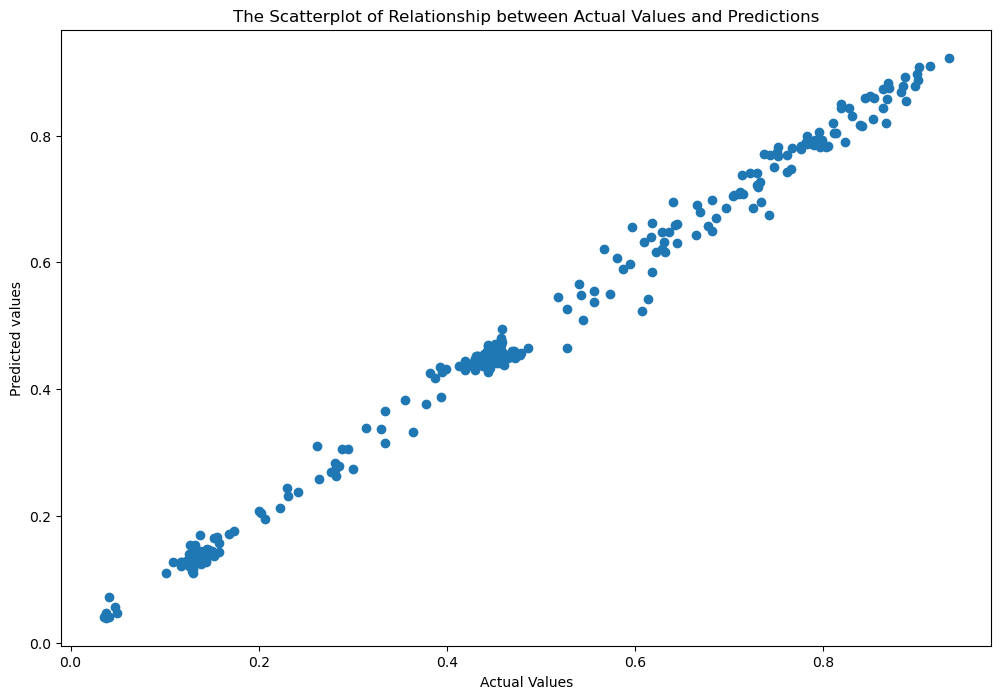

In [145]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])